# Filter Arguments for Validation Experiments
This script inferes topic loadings and check the filtering criteria for the three validation experiments.
We highlight the difference between the original 100 step Semi-Nonnegative Matrix Factorization (SNMF) approach and the CVXPY appraoch to inferring topic loadings and predicting responses for new documents. 

In [1]:
from pathlib import Path

import torch 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from textwrap import TextWrapper

from suntm import SunTopic

# Define the data directory
data_dir = Path.cwd().parent / 'data'
figures_dir = Path.cwd().parent / 'figures'

In [2]:
# import original argument data
df = pd.read_excel(data_dir / "Original_Argument_Collection_with_BT_Score_and_Topics.xlsx")

# import argument embeddings 
embeddings = torch.load(data_dir / "Original_Argument_Collection_Embeddings.pt")

embeddings_train = embeddings[df.Training_set == 1]
embeddings_test = embeddings[df.Training_set == 0]
embeddings_model_fit = embeddings[df.model_fit_idx == 1]
print(f"{embeddings_train.shape = }")

embeddings_train.shape = torch.Size([804, 1536])


## Validation Study 1

In [3]:
df_val1 = pd.read_excel(data_dir / "Validation_Study1_Arguments_with_Topics.xlsx")

## Load embeddings of arguments used in Validation Study 1 
embeddings_val1 = torch.load(data_dir / "Validation_Study1_Embeddings.pt")

## standardize test data using the training data mean and standard deviation
Y_train = np.array(df.BT_Score[df.model_fit_idx == 1])
X_train = np.array(embeddings_model_fit)

# Generate X_norm_scaled for original argument data
X = np.array(embeddings)
X_norm = (X - np.mean(X_train, axis=0))/(np.std(X_train,axis=0))
X_norm_scaled = X_norm /(X_norm.shape[1]**0.1)

# Generate X_norm_scaled for Validation Study 1 data
X = np.array(embeddings_val1)
X_norm = (X - np.mean(X_train, axis=0))/(np.std(X_train,axis=0))
X_norm_scaled_val1 = X_norm /(X_norm.shape[1]**0.1)

# Load saved topic model
model = SunTopic(Y_train, X_train, alpha = 0.5, num_bases = 10, random_state = 44)
model = model.load("suntopic_model_topics10_44RandomState_0.5Alpha_0.2testsize.npz")

In [6]:
# Infer original argument data
Y_pred_val1_all = np.zeros(X_norm_scaled_val1.shape[0])
W_pred_val1_all = np.zeros((X_norm_scaled_val1.shape[0],10))

# for i in range(55):
#     Y_pred_val1_all[i], W_pred_val1_all[i] = model.predict(X_new=X_norm_scaled_val1[i,:],  random_state=44, niter=100, topic_err_tol= 10**-10, return_topics=True)

Y_pred_val1_all[:55], W_pred_val1_all[:55] = model.predict(X_new=X_norm_scaled_val1[:55,:], random_state=44, niter=100, topic_err_tol= 10**-10, return_topics=True)

Y_pred_old_all_args, W_pred_old_all_args = model.predict(X_new=X_norm_scaled, random_state=44, niter=100, topic_err_tol= 10**-10, return_topics=True)
W_pred_val1_all[55:,:] = W_pred_old_all_args[df_val1.Arg_ID[55:],:]

Y_pred_val1_all =  np.dot(W_pred_val1_all, model.get_coefficients()[:,-1])*(0.5**(-0.5))

for i in range(10):
    df_val1[f"topic_{i+1}_inf"] = W_pred_val1_all[:,i]
df_val1['Y_pred'] = Y_pred_val1_all

In [7]:
Y_pred_val1_all = np.zeros(X_norm_scaled_val1.shape[0])
W_pred_val1_all = np.zeros((X_norm_scaled_val1.shape[0],10))

# Infer topics for new and original arguments
Y_pred_val1_all[:55], W_pred_val1_all[:55] = model.predict(X_new=X_norm_scaled_val1[:55,:], random_state=44, niter=100, topic_err_tol= 10**-10, return_topics=True)
Y_pred_old_all_args, W_pred_old_all_args = model.predict(X_new=X_norm_scaled, random_state=44, niter=100, topic_err_tol= 10**-10, return_topics=True)

W_pred_val1_all[55:,:] = W_pred_old_all_args[df_val1.Arg_ID[55:],:]
Y_pred_val1_all[55:] = Y_pred_old_all_args[df_val1.Arg_ID[55:]]


for i in range(10):
    df_val1[f"topic_{i+1}_inf"] = W_pred_val1_all[:,i]
df_val1['Y_pred'] = Y_pred_val1_all

In [8]:
def evaluate_predictions_and_topics(Y_pred1, W_pred1, df_val1):
    # Initialize the lists to store indices of violations
    SY_pred_violations_arg1 = []
    SY_pred_violations_arg2 = []
    SY_topic_violations_arg1 = []
    SY_topic_violations_arg2 = []

    SE_pred_violations_arg = []
    SE_topic_violations_arg = []

    # Loop over the first 30 rows
    for i in range(30):
        if df_val1.arg1[i] is not None:
            condition_arg1 = (Y_pred1[i] < Y_pred1[df_val1.Arg_ID == df_val1.arg1[i]])
            if condition_arg1.any():
                SY_pred_violations_arg1.append(i)

        if df_val1.arg2[i] is not None:
            condition_arg2 = (Y_pred1[i] < Y_pred1[df_val1.Arg_ID == df_val1.arg2[i]])
            if condition_arg2.any():
                SY_pred_violations_arg2.append(i)

        if df_val1.topic1[i] is not None and df_val1.topic2[i] is not None:
            # Get the indices of the top 2 values in W_pred1[i]
            top2_topics = W_pred1[i].argsort()[-2:][::-1]  # Get the indices of the two largest values
            
            topic1_index = int(df_val1.topic1[i] - 1)
            topic2_index = int(df_val1.topic2[i] - 1)

            # Check if the top 2 values match the expected topic1 and topic2
            if topic1_index not in top2_topics:
                SY_topic_violations_arg1.append(i)

            if topic2_index not in top2_topics:
                SY_topic_violations_arg2.append(i)

    # Loop over rows 30 to 45
    for i in range(30, 45):
        if df_val1.arg1[i] is not None:
            condition_arg1 = (Y_pred1[i] < Y_pred1[df_val1.Arg_ID == df_val1.arg1[i]])
            if condition_arg1.any():
                SE_pred_violations_arg.append(i)

        if df_val1.topic1[i] is not None:
            condition_topic1 = (W_pred1[i, int(df_val1.topic1[i] - 1)] < W_pred1[df_val1.Arg_ID == df_val1.arg1[i], int(df_val1.topic1[i] - 1)])
            if condition_topic1.any():
                SE_topic_violations_arg.append(i)

    # Print violations
    print("SY_pred_violations_arg1:", SY_pred_violations_arg1)
    print("SY_pred_violations_arg2:", SY_pred_violations_arg2)
    print("SY_topic_violations_arg1:", SY_topic_violations_arg1)
    print("SY_topic_violations_arg2:", SY_topic_violations_arg2)

    print("SE_pred_violations_arg:", SE_pred_violations_arg)
    print("SE_topic_violations_arg:", SE_topic_violations_arg)

    args_exclude = set(SY_pred_violations_arg1 + SY_pred_violations_arg2 + 
                                                           SY_topic_violations_arg1 + SY_topic_violations_arg2 + 
                                                           SE_pred_violations_arg + SE_topic_violations_arg)
    args_exclude = list(args_exclude)
    args_exclude.sort()
    print(f"{len(args_exclude)} Arguments to exclude from the evaluation:", args_exclude)


In [9]:
evaluate_predictions_and_topics(Y_pred_val1_all, W_pred_val1_all, df_val1)

SY_pred_violations_arg1: []
SY_pred_violations_arg2: [16]
SY_topic_violations_arg1: []
SY_topic_violations_arg2: []
SE_pred_violations_arg: []
SE_topic_violations_arg: []
1 Arguments to exclude from the evaluation: [16]


In [10]:
# Use CVXPY to infer topics and predict responnses to reevaluate the filtering
Y_pred1, W_pred1 = model.predict(X_new=X_norm_scaled_val1, cvxpy=True, random_state=44, return_topics=True)
evaluate_predictions_and_topics(Y_pred1, W_pred1, df_val1)

SY_pred_violations_arg1: []
SY_pred_violations_arg2: [3, 13, 16, 17, 20, 24]
SY_topic_violations_arg1: [3, 11, 18, 20]
SY_topic_violations_arg2: [2, 6, 11, 12, 18, 22, 29]
SE_pred_violations_arg: [31, 33, 34, 36, 41]
SE_topic_violations_arg: [41]
18 Arguments to exclude from the evaluation: [2, 3, 6, 11, 12, 13, 16, 17, 18, 20, 22, 24, 29, 31, 33, 34, 36, 41]


In [11]:
df_val1['pass_filter'] = 1
df_val1.loc[[16], 'pass_filter',] = 0

df_val1['pass_filter_cvxpy'] = 1
df_val1.loc[[2, 3, 6, 11, 12, 13, 16, 17, 18, 20, 22, 24, 29, 31, 33, 34, 36, 41], 'pass_filter_cvxpy'] = 0

df_val1.to_excel(data_dir / "Validation_Study1_Arguments_with_Topics.xlsx", index=False)

## Validation Study 3

In [12]:
df_val3 = pd.read_excel(data_dir / "Validation_Study3_Arguments_with_Topics.xlsx")

## Load embeddings of arguments used in Validation Study 1 
embeddings_val3 = torch.load(data_dir / "Validation_Study3_Embeddings.pt")

## standardize test data using the training data mean and standard deviation
Y_train = np.array(df.BT_Score[df.model_fit_idx == 1])
X_train = np.array(embeddings_model_fit)

# Generate X_norm_scaled for Validation Study 3 data
X = np.array(embeddings_val3)
X_norm = (X - np.mean(X_train, axis=0))/(np.std(X_train,axis=0))
X_norm_scaled_val3 = X_norm /(X_norm.shape[1]**0.1)

# Load saved topic model
model = SunTopic(Y_train, X_train, alpha = 0.5, num_bases = 10, random_state = 44)
model = model.load("suntopic_model_topics10_44RandomState_0.5Alpha_0.2testsize.npz")

In [13]:
def evaluate_predictions_val3(Y_pred3, W_pred3, df_val3):
    # Initialize the lists to store indices of violations
    proto_arg_violations_higher = []
    topic1_violations_lower = []
    proto_arg_violations_lower = []
    topic1_violations_higher = []

    # Loop over the first 80 rows
    for i in range(0, 80):
        if df_val3.topic1[i] is not None:
            condition_topic1 = (W_pred3[i, 1] > W_pred3[i + 100, 1])
            if not condition_topic1:
                topic1_violations_lower.append(i)

    # Loop over the last 20 rows
    for i in range(80, 100):
        if df_val3.topic1[i] is not None:
            condition_topic1 = (W_pred3[i, 1] > W_pred3[i + 100, 1])
            if condition_topic1:
                topic1_violations_higher.append(i)

    print("Topic violations (lower):", topic1_violations_lower)
    print("Topic violations (higher):", topic1_violations_higher)

    args_exclude = set(proto_arg_violations_higher + topic1_violations_lower + proto_arg_violations_lower + topic1_violations_higher)
    args_exclude = list(args_exclude)
    args_exclude.sort()
    print(f"{len(args_exclude)} Arguments to exclude from the evaluation:", args_exclude)



In [14]:
Y_pred_val3_all = np.zeros(X_norm_scaled_val3.shape[0])
W_pred_val3_all = np.zeros((X_norm_scaled_val3.shape[0],10))

# Infer topics for new and original arguments
Y_pred_val3_all[:100], W_pred_val3_all[:100] = model.predict(X_new=X_norm_scaled_val3[:100,:],  random_state=44, niter=100, topic_err_tol= 10**-10, return_topics=True)
Y_pred_old_all_args, W_pred_old_all_args = model.predict(X_new=X_norm_scaled,  random_state=44, niter=100, topic_err_tol= 10**-10, return_topics=True)

W_pred_val3_all[100:,:] = W_pred_old_all_args[df_val3.Arg_ID[100:],:]
Y_pred_val3_all[100:] = Y_pred_old_all_args[df_val3.Arg_ID[100:]]


for i in range(10):
    df_val3[f"topic_{i+1}_inf"] = W_pred_val3_all[:,i]
df_val3['Y_pred'] = Y_pred_val3_all

evaluate_predictions_val3(Y_pred_val3_all, W_pred_val3_all, df_val3)

Topic violations (lower): []
Topic violations (higher): []
0 Arguments to exclude from the evaluation: []


In [15]:
# No need to infer separately for cvxpy inference
Y_pred_val3_all_cvxpy, W_pred_val3_all_cvxpy = model.predict(X_new=X_norm_scaled_val3,  random_state=44, niter=100, topic_err_tol= 10**-10, return_topics=True, cvxpy=True)

for i in range(10):
    df_val3[f"topic_{i+1}_inf_cvxpy"] = W_pred_val3_all_cvxpy[:,i]
df_val3['Y_pred_cvxpy'] = Y_pred_val3_all_cvxpy

evaluate_predictions_val3(Y_pred_val3_all_cvxpy, W_pred_val3_all_cvxpy, df_val3)

Topic violations (lower): [4, 5, 15, 16, 17, 19, 20, 26, 27, 30, 38, 47, 70]
Topic violations (higher): []
13 Arguments to exclude from the evaluation: [4, 5, 15, 16, 17, 19, 20, 26, 27, 30, 38, 47, 70]


In [16]:
df_val3['pass_filter'] = 1

df_val3['pass_filter_cvxpy'] = 1
df_val3.loc[[4, 5, 15, 16, 17, 19, 20, 26, 27, 30, 38, 47, 70], 'pass_filter_cvxpy'] = 0

df_val3.to_excel(data_dir / "Validation_Study3_Arguments_with_Topics.xlsx", index=False)

## Additional Visualization of Topic Changes

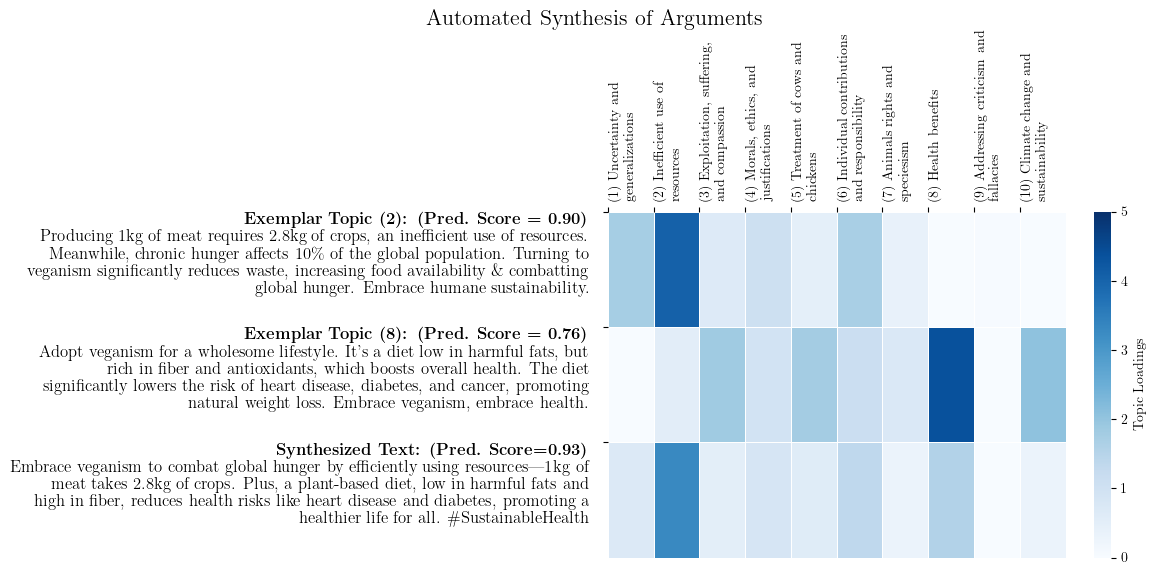

In [17]:
# Create figure of topic loadings using the original topic inference method

plt.rcParams['text.usetex'] = True

# Input indices and latent topics
idx = [69, 84, 6]
arg_topics = [int(df_val1.topic1[idx[-1]]), int(df_val1.topic2[idx[-1]])]
latent_topics = [f"topic_{i+1}_inf" for i in range(10)]

# Manual topic labels
manual_topic_labels = [
    "Uncertainty and generalizations",
    "Inefficient use of resources",
    "Exploitation, suffering, and compassion",
    "Morals, ethics, and justifications",
    "Treatment of cows and chickens",
    "Individual contributions and responsibility",
    "Animals rights and speciesism",
    "Health benefits",
    "Addressing criticism and fallacies",
    "Climate change and sustainability",
]

# List of characters to escape for LaTeX
special_chars = {
    '#': r'\#',
    '%': r'\%',
    '$': r'\$',
    '_': r'\_',
    '{': r'\{',
    '}': r'\}',
    '&': r'\&',
}

# Function to escape special characters in text
def escape_latex(text):
    for char, escaped_char in special_chars.items():
        text = text.replace(char, escaped_char)
    return text

# Initialize TextWrapper
wrapper = TextWrapper(width=80)

# Prepare the loadings DataFrame (assuming df_val1 is defined)
loadings = df_val1.loc[idx, ['Argument'] + latent_topics + ['topic1', 'topic2', 'Y_pred', 'Y_pred_cvxpy']]

texts = loadings['Argument'].tolist()

# Apply wrapping and escaping to the texts
wrapped_texts = [wrapper.fill(escape_latex(text)) for text in texts]

# Add labels to the wrapped texts
wrapped_texts[0] = f"\\textbf{{Exemplar Topic ({arg_topics[0]}): (Pred. Score = {loadings['Y_pred'].iloc[0]:.2f})}}" + "\n" + wrapped_texts[0]
wrapped_texts[1] = f"\\textbf{{Exemplar Topic ({arg_topics[1]}): (Pred. Score = {loadings['Y_pred'].iloc[1]:.2f})}}" + "\n" + wrapped_texts[1]
wrapped_texts[2] = f"\\textbf{{Synthesized Text: (Pred. Score={loadings['Y_pred'].iloc[2]:.2f})}}" + "\n" + wrapped_texts[2]

# Create the figure and heatmap
fig, ax = plt.subplots(figsize=(12, 6))  # Increased height
fig.suptitle("Automated Synthesis of Arguments", y=0.95, fontsize=16)

# Create heatmap
sns.heatmap(
    data=loadings.iloc[:, 1:11],
    cmap='Blues',
    cbar_kws={"label": "Topic Loadings"},
    ax=ax,
    linewidths=0.5,
    vmin=0,  # Minimum value for color scale
    vmax=5   # Maximum value for color scale
)

# Prepare X-axis labels
textwrap = TextWrapper(width=25)
xlabs = [f"({i+1}) " + textwrap.fill(t) for i, t in enumerate(manual_topic_labels)]

# Set Y-axis labels with proper wrapping
ax.set_yticks(range(len(texts)))
ax.set_yticklabels(wrapped_texts, rotation=0, ha='right', va='top', fontsize=12)  # Center vertically

# Adjust padding to align the labels with the heatmap
ax.tick_params(axis='y', which='major', pad=10)

# Move the X-ticks to the top
ax.xaxis.set_ticks_position('top')

# Set X-tick labels with desired rotation
ax.set_xticks(range(len(xlabs)))  # Set the tick positions
ax.set_xticklabels(xlabs, rotation=90, ha='left', va ='bottom', fontsize=10)  # Center text

# Shift x-tick labels slightly to the right
shift_amount = 0.25  # Adjust this value for shifting
for label in ax.get_xticklabels():
    label.set_x(label.get_position()[0] + shift_amount)

ax.axhline(y=len(xlabs), lw=2, color='.1', snap=False)

# Set font to Computer Modern
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

# Tight layout for better positioning
plt.tight_layout()

# Show plot
plt.show()


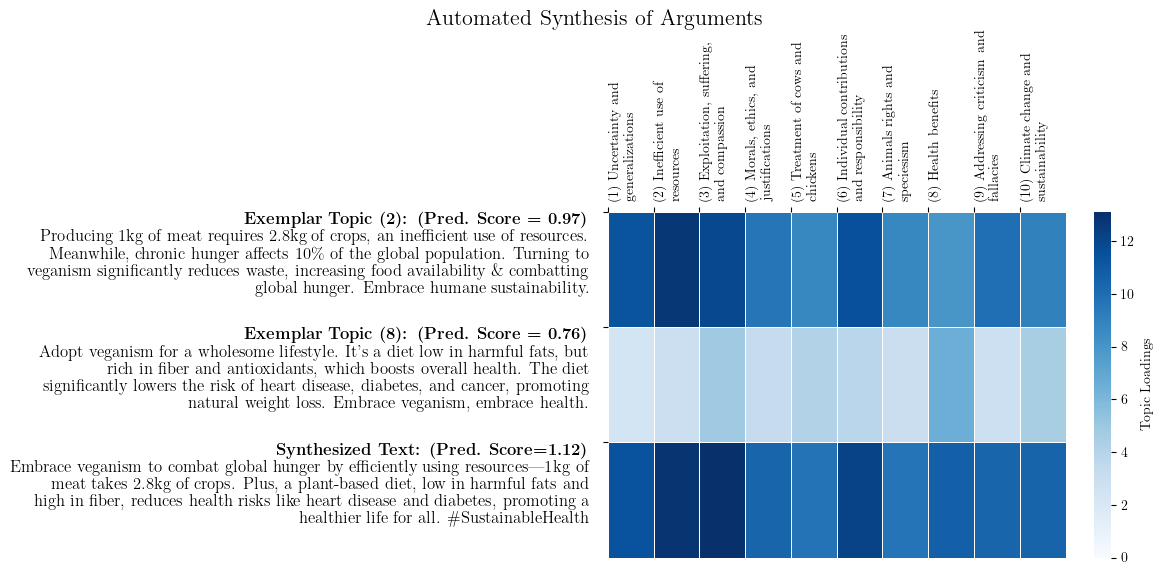

In [18]:
# Recreate figure with cvxpy topic loadings

# Input indices and latent topics
idx = [69, 84, 6]
arg_topics = [int(df_val1.topic1[idx[-1]]), int(df_val1.topic2[idx[-1]])]
latent_topics = [f"topic_{i+1}_inf_cvxpy" for i in range(10)]


# Initialize TextWrapper
wrapper = TextWrapper(width=80)

# Prepare the loadings DataFrame (assuming df_val1 is defined)
loadings = df_val1.loc[idx, ['Argument'] + latent_topics + ['topic1', 'topic2', 'Y_pred', 'Y_pred_cvxpy']]

texts = loadings['Argument'].tolist()

# Apply wrapping and escaping to the texts
wrapped_texts = [wrapper.fill(escape_latex(text)) for text in texts]

# Add labels to the wrapped texts
wrapped_texts[0] = f"\\textbf{{Exemplar Topic ({arg_topics[0]}): (Pred. Score = {loadings['Y_pred_cvxpy'].iloc[0]:.2f})}}" + "\n" + wrapped_texts[0]
wrapped_texts[1] = f"\\textbf{{Exemplar Topic ({arg_topics[1]}): (Pred. Score = {loadings['Y_pred_cvxpy'].iloc[1]:.2f})}}" + "\n" + wrapped_texts[1]
wrapped_texts[2] = f"\\textbf{{Synthesized Text: (Pred. Score={loadings['Y_pred_cvxpy'].iloc[2]:.2f})}}" + "\n" + wrapped_texts[2]

# Create the figure and heatmap
fig, ax = plt.subplots(figsize=(12, 6))  # Increased height
fig.suptitle("Automated Synthesis of Arguments", y=0.95, fontsize=16)

# Create heatmap
sns.heatmap(
    data=loadings.iloc[:, 1:11],
    cmap='Blues',
    cbar_kws={"label": "Topic Loadings"},
    ax=ax,
    linewidths=0.5,
    vmin=0,  # Minimum value for color scale
    # vmax=5   # Maximum value for color scale
)

# Prepare X-axis labels
textwrap = TextWrapper(width=25)
xlabs = [f"({i+1}) " + textwrap.fill(t) for i, t in enumerate(manual_topic_labels)]

# Set Y-axis labels with proper wrapping
ax.set_yticks(range(len(texts)))
ax.set_yticklabels(wrapped_texts, rotation=0, ha='right', va='top', fontsize=12)  # Center vertically

# Adjust padding to align the labels with the heatmap
ax.tick_params(axis='y', which='major', pad=10)

# Move the X-ticks to the top
ax.xaxis.set_ticks_position('top')

# Set X-tick labels with desired rotation
ax.set_xticks(range(len(xlabs)))  # Set the tick positions
ax.set_xticklabels(xlabs, rotation=90, ha='left', va ='bottom', fontsize=10)  # Center text

# Shift x-tick labels slightly to the right
shift_amount = 0.25  # Adjust this value for shifting
for label in ax.get_xticklabels():
    label.set_x(label.get_position()[0] + shift_amount)

ax.axhline(y=len(xlabs), lw=2, color='.1', snap=False)

# Set font to Computer Modern
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

# Tight layout for better positioning
plt.tight_layout()

# Show plot
plt.show()


## Additional Visualiztaion of Difference in Topic Inference Results
Figures to visualize the differences of the inferred topic loadings on the argument of Validation Study 1.
We are comparing the original 100 step SNMF inference (early stopping) with the CVXPY method. 
We also explore how much the original method depends on initilization.

In [19]:
Y_pred_val1_single = np.zeros(X_norm_scaled_val1.shape[0])
W_pred_val1_single = np.zeros((X_norm_scaled_val1.shape[0],10))

# Infer topics for new and original arguments
for i in range(100):
    Y_pred_val1_single[i], W_pred_val1_single[i] = model.predict(X_new=X_norm_scaled_val1[i,:],  random_state=2024, niter=500, topic_err_tol= 10**-10, return_topics=True)

df_val1['Y_pred_single']= Y_pred_val1_single
for i in range(0,10):
    df_val1[f"topic_{i+1}_inf_single"] = W_pred_val1_single[:,i]


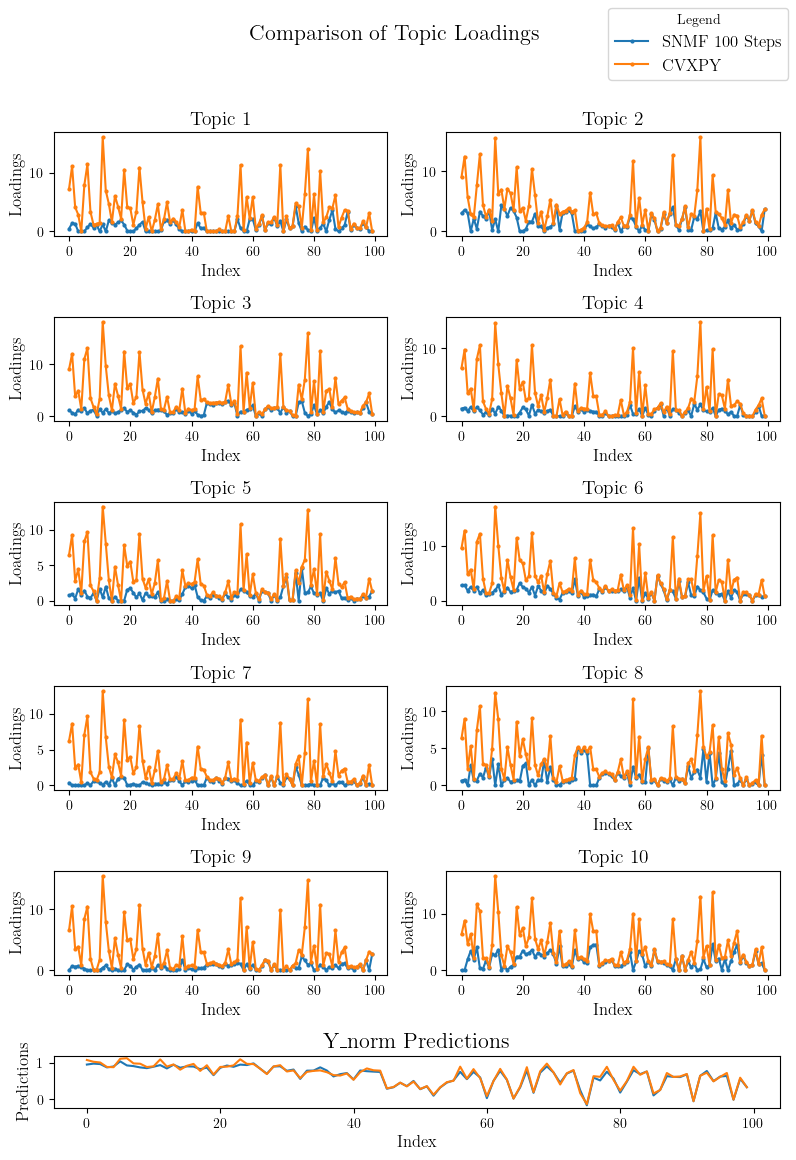

In [20]:
# Assuming df_val1 is your DataFrame and already defined
# Check if the DataFrame contains the expected columns
topic_columns = [f'topic_{i}_inf' for i in range(1, 11)] + [f'topic_{i}_inf_cvxpy' for i in range(1, 11)]
if not all(col in df_val1.columns for col in topic_columns):
    raise ValueError("One or more topic columns are missing in the DataFrame.")

# Create a figure with a specific GridSpec
fig = plt.figure(figsize=(8, 12))
gs = GridSpec(6, 2, height_ratios=[1, 1, 1, 1, 1, 0.5])  # Last row will be smaller

fig.suptitle("Comparison of Topic Loadings", fontsize=16)

# Iterate through the topics
for i in range(10):  # 0 to 9 for topics 1 to 10
    # Select the axes for the current subplot
    ax = fig.add_subplot(gs[i // 2, i % 2])  # Correctly determine subplot position

    # Plot the topic_i_inf and topic_i_inf_cvxpy without legends
    df_val1[['topic_{}_inf'.format(i + 1), 
             'topic_{}_inf_cvxpy'.format(i + 1)]].plot(ax=ax, legend=False, marker='o', markersize=2)
    # Set titles and labels
    ax.set_title(f"Topic {i + 1}", fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Loadings", fontsize=12)

# Add a subplot that spans both columns at the bottom
ax_bottom = fig.add_subplot(gs[5, :])  # Create a subplot that spans both columns

# Plot Y_pred and Y_pred_cvxpy without a legend
df_val1[['Y_pred', 'Y_pred_cvxpy']].plot(ax=ax_bottom, legend=False)

# Set title and labels for the bottom plot
ax_bottom.set_title("Y_norm Predictions", fontsize=16)
ax_bottom.set_xlabel("Index", fontsize=12)
ax_bottom.set_ylabel("Predictions", fontsize=12)

# Create a unified legend
handles, labels = ax.get_legend_handles_labels()  # Get handles from the last subplot created
fig.legend(handles, ['SNMF 100 Steps', 'CVXPY'], loc='upper right', fontsize=12, title='Legend')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title and legend
plt.show()


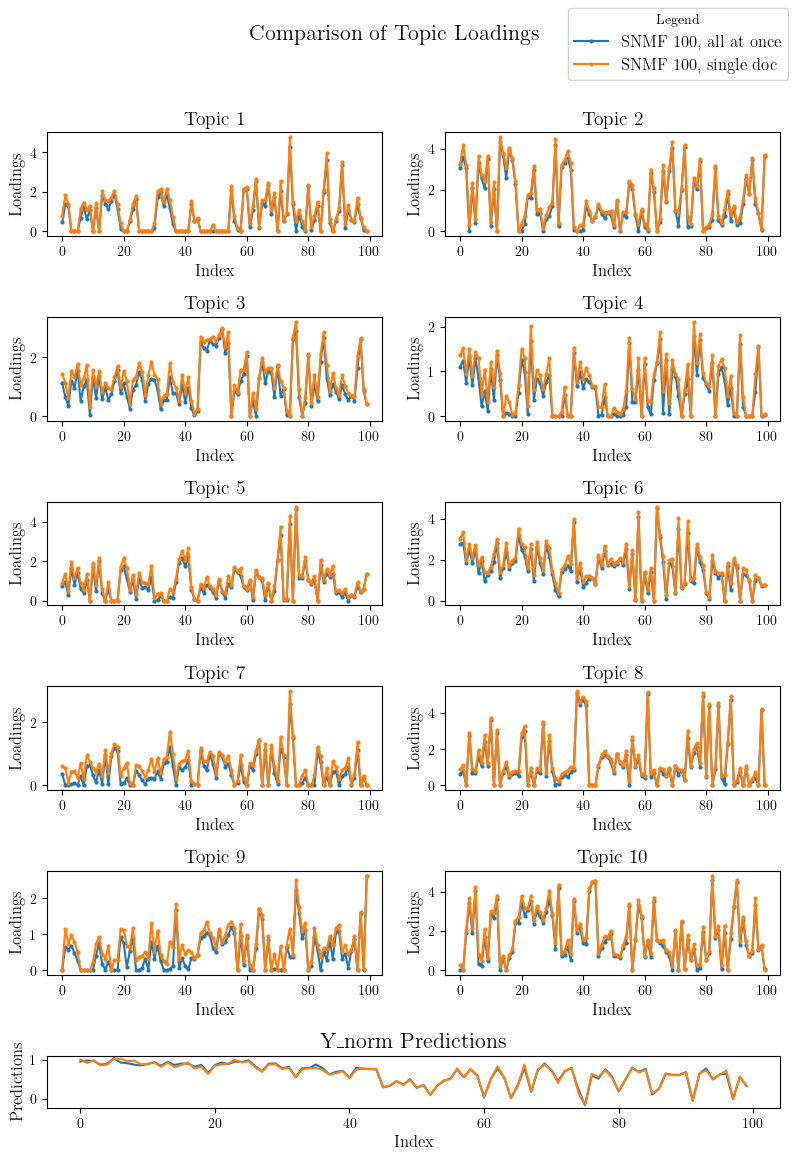

In [21]:

# Assuming df_val1 is your DataFrame and already defined
# Check if the DataFrame contains the expected columns
topic_columns = [f'topic_{i}_inf' for i in range(1, 11)] + [f'topic_{i}_inf_single' for i in range(1, 11)]
if not all(col in df_val1.columns for col in topic_columns):
    raise ValueError("One or more topic columns are missing in the DataFrame.")

# Create a figure with a specific GridSpec
fig = plt.figure(figsize=(8, 12))
gs = GridSpec(6, 2, height_ratios=[1, 1, 1, 1, 1, 0.5])  # Last row will be smaller

fig.suptitle("Comparison of Topic Loadings", fontsize=16)

# Iterate through the topics
for i in range(10):  # 0 to 9 for topics 1 to 10
    # Select the axes for the current subplot
    ax = fig.add_subplot(gs[i // 2, i % 2])  # Correctly determine subplot position

    # Plot the topic_i_inf and topic_i_inf_cvxpy without legends
    df_val1[['topic_{}_inf'.format(i + 1), 
             'topic_{}_inf_single'.format(i + 1)]].plot(ax=ax, legend=False, marker='o', markersize=2)

    # Set titles and labels
    ax.set_title(f"Topic {i + 1}", fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Loadings", fontsize=12)

# Add a subplot that spans both columns at the bottom
ax_bottom = fig.add_subplot(gs[5, :])  # Create a subplot that spans both columns

# Plot Y_pred and Y_pred_cvxpy without a legend
df_val1[['Y_pred', 'Y_pred_single']].plot(ax=ax_bottom, legend=False)

# Set title and labels for the bottom plot
ax_bottom.set_title("Y_norm Predictions", fontsize=16)
ax_bottom.set_xlabel("Index", fontsize=12)
ax_bottom.set_ylabel("Predictions", fontsize=12)

# Create a unified legend
handles, labels = ax.get_legend_handles_labels()  # Get handles from the last subplot created
fig.legend(handles, ['SNMF 100, all at once', 'SNMF 100, single doc'], loc='upper right', fontsize=12, title='Legend')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title and legend
plt.show()
